In [1]:
import torch
import pybullet
import matplotlib.pyplot as plt
from locomotion.envs.gym_envs import A1GymEnv
from dynamics import *
import os

In [2]:
# Init the NN dynamics model
dynamics_function = Dynamics(
    n_in=31,
    n_hidden=30,
    n_out=19,
    depth=20,
)

# Create the robot environment
env = A1GymEnv(action_limit=(0.75, 0.75, 0.75), render=False, on_rack=False)
# Set lateral friction to 0.7
pybullet.changeDynamics(env._world_dict["ground"], -1, lateralFriction=0.7)

c:\Users\darsh\Desktop\model_based_locomotion\venv\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Train Episode 1: Average Loss: 8.371122
Train Episode 2: Average Loss: 8.444248
Train Episode 3: Average Loss: 8.023106
Train Episode 4: Average Loss: 8.157576
Train Episode 5: Average Loss: 7.944385
Train Episode 6: Average Loss: 8.435508
Train Episode 7: Average Loss: 8.291718
Train Episode 8: Average Loss: 8.310659
Train Episode 9: Average Loss: 7.907238
Train Episode 10: Average Loss: 7.360879
Train Episode 11: Average Loss: 6.291816
Train Episode 12: Average Loss: 5.661017
Train Episode 13: Average Loss: 5.201143
Train Episode 14: Average Loss: 4.962507
Train Episode 15: Average Loss: 5.007072
Train Episode 16: Average Loss: 4.707206
Train Episode 17: Average Loss: 4.661750
Train Episode 18: Average Loss: 4.573962
Train Episode 19: Average Loss: 4.310691
Train Episode 20: Average Loss: 4.160590


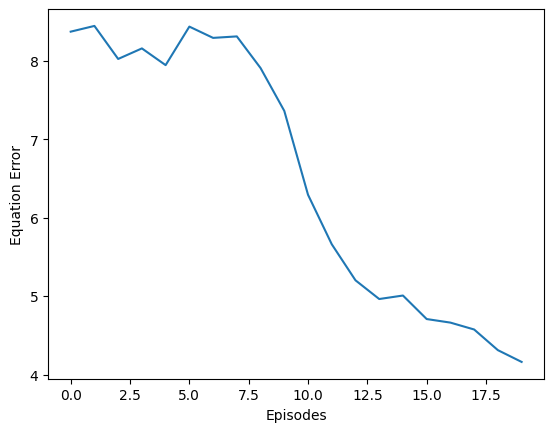

In [3]:
optimizer = torch.optim.Adam(dynamics_function.parameters(), lr = 1e-4)
loss_history = train_dynamics(
    dynamics=dynamics_function,
    env=env,
    optimizer=optimizer,
    num_episodes=20,
    len_episode=2000,
    device="cpu",
    pred_delta=True,      # True for predicting the change in state(pred_st_1 - st_1), False for predicting next state(pred_st_1)
    output_dir="./logs"
)

plt.plot(loss_history)
plt.ylabel("Equation Error")
plt.xlabel("Episodes")
if not os.path.exists("./logs"):
    os.mkdir("./logs")
plt.savefig("./logs/delta_loss_1.png")